# **TCC_p07_Sumarização_Sumy_DCNN.ipynb**

# Etapa 1: Importação das bibliotecas e montagem do Drive

1.   Importação de bibliotecas

* Pandas: para criação e manipulação de dataframes
* re: para utilização das expressões regulares em operações de transformações em string.
* numpy: para trabalhar com array.
* string: para importar sinais de pontuação.
* seaborn: biblioteca para visualização de dados baseada em Matplotlib para exibir a matriz de confusão do sklearn como mapa de calor e as contagens de observações em cada categoria categórica usando barras.
* matplotlib: biblioteca para a criação de visualizações estáticas, animadas e interativas em Python. Utilizada para fazer alterações nas figuras: por exemplo, criar uma figura, criar uma área de plotagem em uma figura, plotar algumas linhas em uma área de plotagem e decorar a plotagem com rótulos.
* sklearn: para utilização das métricas de classificação matriz de confusão e acurácia.

2. Importação do TensorFlow
* Tokenizer: a classe TensorFlow (Keras) Tokenizer é usada para automatizar a tokenização de nossos dados de treinamento e converter os textos em sequências númericas.
* pad_sequences: usada para preencher todas as sequências com zeros extras ao final para que todas as sequências tenham o mesmo comprimento. 

3. Importação da biblioteca de sumarização Sumy
* Biblioteca simples e utilitário de linha de comando para extrair resumos de páginas HTML ou textos simples. Foi a biblioteca escolhida para a maioria dos sumarizadores utilizados no TCC. Neste notebook, foram importados os três sumarizadores escolhidos para a pesquisa: LsaSummarizer, TextRankSummarizer, EdmundsonSummarizer, LuhnSummarizer, LexRankSummarizer, SumBasicSummarizer e RandomSummarizer.
* PlaintextParser e Tokenizer para fazer a análise sintática e a tokenização do texto permitindo que os sumarizadores avaliem as sentenças conforme seus critérios. A documentação da biblioteca não dá maiores detalhes.

4. Importação da biblioteca SpaCy e NLTK
* Neste notebook, a SpaCy é utilizada para instanciar um Doc, um contêiner para acessar anotações linguísticas tokenizadas na função preprocessamento.
* nltk: usada para tokenizar textos em sentenças dos votos e dos resumos para a impressão do pdf com os resumos.
* nltk punkt: Punkt é uma ferramenta de segmentação de frases neutra em termos de linguagem utilizada na tokenização.
* nltk: para obter pacote para stemização.

5. Montar Drive
*   Com ***drive.mount***('/content/drive', force_remount=True) os diretórios de dados do ***Google Drive*** são montados para utilização no ***Colab*** permitindo salvar arquivos e modelos treinados para utilização posterior, inclusive, em outros notebooks.

##1.   Importação de bibliotecas

In [ ]:
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

##2. Importação do TensorFlow

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.4.1'

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer as TokenizerTS
from tensorflow.keras.preprocessing.sequence import pad_sequences

##3. Importação da biblioteca sumy

- https://pypi.org/project/sumy/

In [ ]:
!pip install sumy

     |████████████████████████████████| 92kB 3.5MB/s 
     |████████████████████████████████| 10.1MB 6.1MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746863 sha256=518fa4cc15fa54de8cbabd476186a314d2a91f77639057a4ad1d26890ecabc28
  Stored in directory: /root/.cache/pip/wheels/33/4e/a6/be297e6b83567e537bed9df4a93f8590ec01c1acfbcd405348
  Created wheel for breadability: filename=breadability-0.1.20-py2.py3-none-any.whl size=21680 sha256=f840f55e72d12d9a3156349788fe88ea5230f323c441131842b0225e28ec6ebf
  Stored in directory: /root/.cache/pip/wheels/5a/4d/a1/510b12c5e65e0b2b3ce539b2af66da0fc57571e528924f4a52
Successfully built pycountry breadability


In [ ]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer as TokenizerSumy
from sumy.summarizers.luhn import LuhnSummarizer
from sumy.summarizers.lsa import LsaSummarizer
from sumy.summarizers.text_rank import TextRankSummarizer
from sumy.summarizers.lex_rank import LexRankSummarizer
from sumy.summarizers.edmundson import EdmundsonSummarizer
from sumy.summarizers.sum_basic import SumBasicSummarizer
from sumy.summarizers.random import RandomSummarizer

#4. Importação da biblioteca spaCy

1.2   Importação de bibliotecas

In [ ]:
!pip install spacy==2.3.5

In [ ]:
import spacy
spacy.__version__

'2.3.5'

In [ ]:
!python -m spacy download pt
import spacy
pln = spacy.load("pt")

In [ ]:
from spacy.lang.pt.stop_words import STOP_WORDS
stop_words_spacy = STOP_WORDS

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('rslp') #stemização
nltk.download('stopwords')
stop_words_nltk = nltk.corpus.stopwords.words('portuguese')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stop_words = set(stop_words_nltk + list(stop_words_spacy))

In [ ]:
pontuacoes = string.punctuation
pontuacoes

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

##5. Montar Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


# Etapa 2: Avaliação na base de teste sumarizada com DCNN

0. Funções
* sumarizar_sumy: função que faz a sumarização do voto de acordo com o tipo de sumarizador da biblioteca Sumy carregado. O resumo do tipo extrativo escolhe as melhores sentenças do voto na proporção 40% melhores. Docstring da função a seguir:

```
  Recebe uma coleção de frases e escolhe as melhores na proporção 40%.
  :parâmetro texto: recebe o texto integral de um voto.
  : retorno melhores_sentencas: string com as 40% melhores sentenças.
```

* preprocessamento: A descrição desta função encontra-se no notebook *TCC_p01_preparar_X_treinamento_e_y_teste*. É a mesma função. 

1.   Carrega o sumarizador a ser testado
* Instanciar o objeto sumarizador para um dos sumarizadores importados: LuhnSummarizer, LsaSummarizer, TextRankSummarizer, LexRankSummarizer, SumBasicSummarizer, RandomSummarizer ou EdmundsonSummarizer.

2.   Carrega o X_teste do Drive
* Os resumos serão aplicados aos mesmos dados de teste utilizados para a classificação. Agora, a base será submetida à classificação após a sumarização dos dados.

3.   Aplica o sumarizador ao voto utilizando a função apply(sumarizar_sumy)

4.   Preprocessamento dos dados de teste
* Faz o preprocessamento dos dados de teste escolhendo lematização, stemização ou mantendo as palavras originais.
* A descrição desta função encontra-se no notebook *TCC_p01_preparar_X_treinamento_e_y_teste*. 

5. Conversão dos votos da base de teste em vetor númerico
5.1 Escolher o tipo de modelo
* O modelo escolhido foi lema porque foi o modelo com melhor desempenho.
5.2 Ler arquivos do Drive gravados pelo notebook TCC_p01_preparar_X_treinamento_e_y_teste
* Lê o dataframe X_treinamento preprocessado com lema, stemer ou palavras originais. No caso, lema.
5.3 Faz a tokenização da base de treinamento
* Repete a tokenização com os dados do treinamento feita no notebook TCC_p03_Classificação_DCNN para
fazer a conversão em vetor númerico dos dados de teste.

6. Transformar as categorias alfabéticas 'irpj', 'irpf', 'ngdt' e 'paf' em numéricas [0, 1, 2, 3]
* Faz a categorização numérica da variável alvo para entrada na rede neural

7. Carga e execução do modelo de melhor desempenho
* Carrega o modelo modelo_Dcnn_lema gravado no drive pelo notebook TCC_p03_Classificação_DCNN que foi o modelo com o melhor desempenho.
* Faz a predição dos dados de teste sumarizados de acordo com o sumarizador carregado

8. Visualização do resultado da classicação com os dados do resumo Edmundson
* Após a predição, compara o resultado predito pelo modelo DCNN com os resultados reais e apresenta a matriz de confusão como mapa de calor e também o resultado da acurácia. O mesmo procedimento será realizado com todos os demais sumarizadores nos itens seguintes.

9. Visualização do resultado da classicação com os dados do resumo LuhnSummarizer

10. Visualização do resultado da classicação com os dados do resumo LexRankSummarizer

11. Visualização do resultado da classicação com os dados do resumo LsaSummarizer 

12. Visualização do resultado da classicação com os dados do resumo SumBasicSummarizer 

13. Visualização do resultado da classicação com os dados do resumo RandomSummarizer 

14. Visualização do resultado da classicação com os dados do resumo TextRankSummarizer

##0. Funçoes

In [ ]:
def sumarizar_sumy(texto):
  """
  Recebe uma coleção de frases e escolhe as melhores na proporção 40%.
  :parâmetro texto: recebe o texto integral de um voto.
  : retorno melhores_sentencas: string com as 40% melhores sentenças.
  """
  parser = PlaintextParser.from_string(texto, TokenizerSumy('portuguese'))
  quantidade_sentencas = int(0.4 * len(parser.document.sentences))
  if quantidade_sentencas < 4:
    quantidade_sentencas = 4

  resumo = sumarizador(parser.document, quantidade_sentencas)
  melhores_sentencas = []
  for sentenca in resumo:
    melhores_sentencas.append(str(sentenca).replace("Sentence: ",""))
  melhores_sentencas = str(melhores_sentencas).replace("',", '').replace("'", '').replace('[', '').replace(']', '')

  return melhores_sentencas

In [ ]:
def preprocessamento(texto, tipo):
  """
  Faz uma limpeza do texto recebido excluíndo pontuações, stop words, números em moedas, leis, etc, letras soltas, palavras com duas letras, 
  hífens iniciais, r$, espaços duplos e símbolos.  
  O objetivo é deixar apenas palavras que serão a base para as classificações.

  :parâmetro texto: recebe o texto integral de um voto.
  :parâmetro tipo: escolher entre 'lema', 'stemer' e 'original'. Lema faz lematização das palavras, stemer faz a stemização e original mantém as palavras sem alterações.
  :retorno str_lista: string com a lista das palavras do voto após a limpeza dos dados.  

  """

  texto = texto.lower()
  texto = re.sub('([¹²³£¢¬§ªº°]{1})', ' ', texto) #excluir o símbolos listados
  texto = re.sub('([!"#%&\'\(\)\*\+,\./:;<=>\?@\[\]\^_`\{\|\}~]{1})', ' ', texto) #excluir as pontuações, exceto o hífen
  texto = re.sub('([0-9]*)[\.]*([0-9]+,[0-9]+)', ' ', texto)  #excluir valores com decimais após vírgulas 10.000,00 30,00
  texto = re.sub('([0-9]+)[.]+([0-9]+)\/([0-9]+)', ' ', texto) #excluir valores tipo leis 9.420/99
  texto = re.sub('([0-9]+)\/([0-9]+)', ' ', texto) #excluir valores tipo leis 70/99
  texto = re.sub('([0-9]+)', ' ', texto) #excluir números
  texto = re.sub('( [a-z]{1} )', ' ', texto) #excluir letras soltas
  texto = re.sub('( [a-z]{2} )', ' ', texto) #excluir palavras com 2 letras
  texto = re.sub(' -([a-z]*)', r'\1', texto) #excluir hífens iniciais
  texto = texto.replace('r$', ' ') #excluir r$
  texto = re.sub('( [ ]*)', ' ', texto) #excluir espaços duplos

  documento = pln(texto)
  lista = [token.text for token in documento if token.text not in stop_words and token.text not in string.punctuation]
  str_lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])
  documento = pln(str_lista)
  
  lista = []
  if tipo == 'lema': # Lematização
    for token in documento:
      lista.append(token.lemma_)  
  elif tipo == 'stemer':
    for token in documento:
      stemmer = nltk.stem.RSLPStemmer()
      lista.append(stemmer.stem(token.text))
  else: #'original' ou qualquer outro valor
    for token in documento:
      lista.append(token.text)    

  str_lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])
  
  return str_lista

##1. Carrega o sumarizador a ser testado

In [ ]:
#Instanciar o objeto sumarizador LuhnSummarizer,LsaSummarizer,TextRankSummarizer,LexRankSummarizer,SumBasicSummarizer,RandomSummarizer,EdmundsonSummarizer
sumarizador = EdmundsonSummarizer()

##2.   Carrega o X_teste do Drive

In [ ]:
#Carregar dataframe X_teste diretamente do drive.
url = '/content/drive/MyDrive/X_teste_1781.csv' 
X_teste = pd.read_csv(url, sep=';', engine='python', encoding='windows-1252', low_memory=True) 

In [ ]:
pd_options = pd.options.display # Objeto para configuração do ambiente: número de linhas, colunas, precisão e etc
pd_options.max_colwidth = 200

In [ ]:
X_teste.head()

,voto
0,"de acordo com o despacho de admissibilidade dos embargos de declaração, o recurso preencheu as condições formais de conhecimento. a primeira omissão a ser suprida é a ausência do relatório. impor..."
1,os fatos que ensejaram a autuação objeto dos presentes autos foram bem relatados no acórdão recorrido. o grupo ultrapar ao adquirir a chevron brasil ltda (texaco) e a sociedade anônima óleo gale...
2,"o recurso é tempestivo e atende aos requisitos de admissibilidade, assim, dele tomo conhecimento. a fiscalização glosou as áreas declaradas de preservação permanente de 1036,9 ha e de reserva le..."
3,"o recurso voluntário apresentado pela recorrente atende aos requisitos formais de admissibilidade assim, dele tomo conhecimento. a partir de 30/12/2003, ficou estabelecido que a per/dcomp constit..."
4,"presente o pressuposto de admissibilidade, por ser tempestivo, conheço do recurso e passo ao exame das alegações recursais. conforme se depreende dos elementos que instruem o processo, o contribu..."


##3.   Aplica o sumarizador ao voto utilizando a função apply(sumarizar_sumy)

In [ ]:
#sumarizar o voto com o sumarizador ativo
X_teste['voto'] = X_teste['voto'].apply(sumarizar_sumy)
X_teste_sumarizado = X_teste.copy()

In [ ]:
X_teste_sumarizado.head()

,voto
0,"de acordo com o despacho de admissibilidade dos embargos de declaração, o recurso preencheu as condições formais de conhecimento. ainda nessa questão, o relatório do presente julgado corrige a om..."
1,"os fatos que ensejaram a autuação objeto dos presentes autos foram bem relatados no acórdão recorrido. analisando os documentos dos autos, verifica-se que houve outras reorganizações societárias..."
2,"tal obrigação encontra amparo na lei 4.771, de 1965 (código florestal), com a redação dada pela lei 7.803, de 1989. destarte, ao fazer referência à lei ambiental, a lei 9.393, de 1996, na verdad..."
3,"entendo que o pedido da recorrente, relativo a per/dcomp 16539.94217.210104.1.3.02-0609, transmitida em 21/01/2004, relativo ao reconhecimento do direito creditório de saldo negativo de irpj, po..."
4,"por sua vez, ao analisar a impugnação e documentos ofertados pelo contribuinte, a autoridade julgadora de primeira instância entendeu por bem manter a ação fiscal, sob o argumento de que no mé..."


##4.   Preprocessamento dos dados de teste

In [ ]:
#rodar preprocessamento selecionando entre lema, stemer ou original. Usar o mesmo utilizado para treinar o modelo.
X_teste_sumarizado['voto'] = X_teste_sumarizado['voto'].apply(preprocessamento, args=(tipo_modelo,))
X_teste_sumarizado_preprocessado = X_teste_sumarizado.copy()

In [ ]:
X_teste_sumarizado_preprocessado.head()

,voto
0,acordar despachar admissibilidade embargo declaração recurso preencher condição formar conhecimento relatório presentar julgar corrigir omissão trazer arrazoar fato relevante início procedimento f...
1,fato ensejar autuação objeto presente auto relatar acórdão recorrer analisar documento auto verifica-se reorganização societário realizar ultrapar fiscalização repercutir diretamente autuação obje...
2,obrigação encontrar amparar lei código florestal redação dar lei destarte referência lei ambiental lei verdade condicionar exclusão tributação arl reservar legal averbação tempestivo respectivo re...
3,entender pedir recorrente relativo per dcomp transmitir relativo reconhecimento direito creditório saldar negativar irpj analisar ter visto entendimento adotado carf pedir restituição pleitear adm...
4,analisar impugnação documento ofertar contribuinte autoridade julgador instância entender manter ação fiscal argumentar mérito interessar acostar comprovante auto afirmar apresentar drf conformar ...


In [ ]:
#transformar X_teste em numpy.ndarray
dados_teste_preprocessados = X_teste_sumarizado_preprocessado.iloc[:, 0].values

##5. Conversão dos votos da base de teste em vetor númerico

5.1 Escolher o tipo de modelo

In [ ]:
#Definir qual é o modelo a ser treinado. Se lematizado, stemizado ou palavras originais.
#A variável tipo_modelo será definida aqui e será utilizada para fazer o direcionamento ao carregar o X_treinamento preprocessado, 
#no preprocessamento de X_teste, ao salvar o modelo, ao carregar o modelo treinado e ao exibir os resultados.
tipo_modelo = 'lema' #escolher 'lema', 'stemer' ou 'original'

5.2 Ler arquivos do Drive gravados pelo notebook TCC_p01_preparar_X_treinamento_e_y_teste

In [ ]:
#Recuperando os arquivos de treinamento após preprocessamento salvos no drive. Verificar qual X irá treinar, se lema, stemer ou origianl.
if tipo_modelo == 'lema':
  url = '/content/drive/MyDrive/X_treinamento_lema.csv'
elif tipo_modelo == 'stemer':
  url = '/content/drive/MyDrive/X_treinamento_stemer.csv'
else:
  url = '/content/drive/MyDrive/X_treinamento_original.csv'
  
X_treinamento = pd.read_csv(url, sep=';', engine='python', encoding='windows-1252', low_memory=True, quotechar='"', error_bad_lines=False)

In [ ]:
#transforma X_treinamento e y_treinamento em numpy.ndarray
X_treinamento_preprocessado = X_treinamento.iloc[:, 0].values

5.3 Faz a tokenização da base de treinamento 

In [ ]:
num_words = 2**16
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

In [ ]:
# Tokenizar os dados de treinamento 
tokenizerTS = TokenizerTS(num_words=num_words, oov_token=oov_token)
tokenizerTS.fit_on_texts(X_treinamento_preprocessado)

# Obter total de palavras de dados de treinamento
vocab_size = len(tokenizerTS.word_index) + 1

In [ ]:
#Informa do valor de max_len utilizado para o padding. Os valores foram obtidos do notebook TCC_p03_Classificação_DCNN quando rodaram-se os modelos.
if tipo_modelo == 'lema':
  max_len = 7622
elif tipo_modelo == 'stemer':
  max_len = 7610
else:
  max_len = 7622

In [ ]:
# Transforma cada texto da base de teste em uma sequência de inteiros com base no tokenizer da base de treinamento
X_teste_vetor_numerico = tokenizerTS.texts_to_sequences(dados_teste_preprocessados)

# Transformar a lista de sequências de tamanho variável em uma matriz 2D numpy de forma (número de linhas, comprimento da maior sequência).
X_teste_vetor_numerico = pad_sequences(X_teste_vetor_numerico, padding=pad_type, truncating=trunc_type, maxlen=max_len)

##6. Transformar as categorias alfabéticas 'irpj', 'irpf', 'ngdt' e 'paf' em numéricas [0, 1, 2, 3]

In [ ]:
#Carrega o y_teste do Drive
url = '/content/drive/MyDrive/y_teste_1781.csv' 
y_teste = pd.read_csv(url, sep=';', engine='python', encoding='windows-1252', low_memory=True)
rotulos_teste = y_teste.iloc[:, 0].values

In [ ]:
#rotulos para o gráfico matriz de confusão
rotulos_plt_cm = ['irpj', 'irpf', 'ngdt', 'paf']

In [ ]:
rotulos_teste[rotulos_teste == 'irpj'] = 0
rotulos_teste[rotulos_teste == 'irpf'] = 1
rotulos_teste[rotulos_teste == 'ngdt'] = 2
rotulos_teste[rotulos_teste == 'paf'] = 3
rotulos_teste = rotulos_teste.astype(np.int32)
rotulos_teste

array([3, 0, 1, ..., 3, 3, 0], dtype=int32)

##7. Carga e execução do modelo de melhor desempenho

In [ ]:
#Carregando modelo treinado com melhor desempenho. O modelo foi salvo no drive.
Dcnn = tf.keras.models.load_model('/content/drive/MyDrive/modelo_Dcnn_lema')

In [ ]:
#Faz a predição
y_pred_test = Dcnn.predict(X_teste_vetor_numerico)
lista_predict = y_pred_test.argmax(axis=1) 

##8. Visualização do resultado da classicação com os dados do resumo Edmundson


In [ ]:
sumarizador

In [ ]:
#Carregar palavras mais frequentes das ementas e da última frase.
url = '/content/drive/MyDrive/df_palavras_ementa.csv' 
df_bonus_words_1 = pd.read_csv(url, sep=';', engine='python', encoding='windows-1252', low_memory=True) 
url = '/content/drive/MyDrive/df_palavras_ultima_frase.csv' 
df_bonus_words_2 = pd.read_csv(url, sep=';', engine='python', encoding='windows-1252', low_memory=True) 
#Carregar palavras stigma com os nomes dos relatores.
url = '/content/drive/MyDrive/df_palavras_relatores.csv' 
df_stigma_words = pd.read_csv(url, sep=';', engine='python', encoding='windows-1252', low_memory=True) 
#Carregar palavras nulas com as stop words.
url = '/content/drive/MyDrive/df_palavras_stop_words.csv' 
df_stop_words = pd.read_csv(url, sep=';', engine='python', encoding='windows-1252', low_memory=True) 

In [ ]:
list_bonus_words = list(pd.concat([df_bonus_words_1, df_bonus_words_2])['0'])
list_stigma_words = list(pd.concat([df_stigma_words, df_stop_words])['0'])

In [ ]:
#Palavras bônus, stigma e nulas para o sumarizador Edmundson.
sumarizador.bonus_words = list_bonus_words
sumarizador.stigma_words = ['ff']
sumarizador.null_words = list_stigma_words

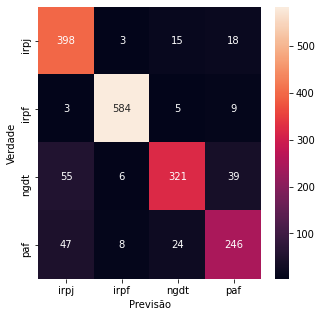

In [ ]:
conf_mat_nb = confusion_matrix(rotulos_teste, lista_predict)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat_nb, annot=True, fmt='d',
            xticklabels=rotulos_plt_cm, yticklabels=rotulos_plt_cm)
plt.ylabel('Verdade')
plt.xlabel('Previsão')
plt.show()

In [ ]:
accuracy_score(rotulos_teste, lista_predict)

0.8697361033127456

In [ ]:
0.8680516563728242 último resultado
Testando agora com palavras stigma. 0.8590679393599102
Final = 0.8697361033127456 1º lugar

##9. Visualização do resultado da classicação com os dados do resumo LuhnSummarizer


In [ ]:
sumarizador

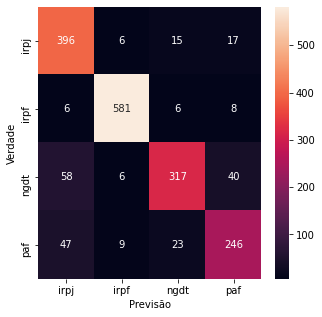

In [ ]:
conf_mat_nb = confusion_matrix(rotulos_teste, lista_predict)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat_nb, annot=True, fmt='d',
            xticklabels=rotulos_plt_cm, yticklabels=rotulos_plt_cm)
plt.ylabel('Verdade')
plt.xlabel('Previsão')
plt.show()

In [ ]:
accuracy_score(rotulos_teste, lista_predict)

0.8646827624929815

##10. Visualização do resultado da classicação com os dados do resumo LexRankSummarizer


In [ ]:
sumarizador

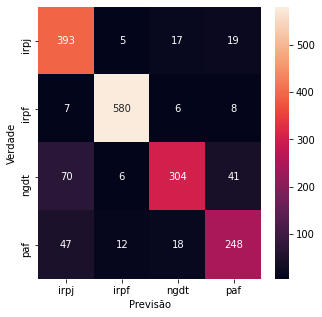

In [ ]:
conf_mat_nb = confusion_matrix(rotulos_teste, lista_predict)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat_nb, annot=True, fmt='d',
            xticklabels=rotulos_plt_cm, yticklabels=rotulos_plt_cm)
plt.ylabel('Verdade')
plt.xlabel('Previsão')
plt.show()

In [ ]:
accuracy_score(rotulos_teste, lista_predict)

0.8562605277933745

##11. Visualização do resultado da classicação com os dados do resumo LsaSummarizer 



In [ ]:
sumarizador

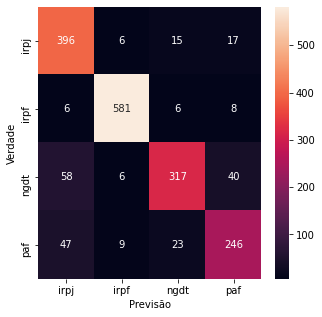

In [ ]:
conf_mat_nb = confusion_matrix(rotulos_teste, lista_predict)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat_nb, annot=True, fmt='d',
            xticklabels=rotulos_plt_cm, yticklabels=rotulos_plt_cm)
plt.ylabel('Verdade')
plt.xlabel('Previsão')
plt.show()

In [ ]:
accuracy_score(rotulos_teste, lista_predict)

0.8646827624929815

##12. Visualização do resultado da classicação com os dados do resumo SumBasicSummarizer 


In [ ]:
sumarizador

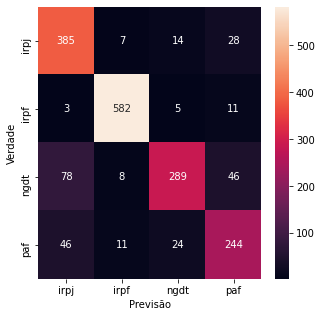

In [ ]:
conf_mat_nb = confusion_matrix(rotulos_teste, lista_predict)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat_nb, annot=True, fmt='d',
            xticklabels=rotulos_plt_cm, yticklabels=rotulos_plt_cm)
plt.ylabel('Verdade')
plt.xlabel('Previsão')
plt.show()

In [ ]:
accuracy_score(rotulos_teste, lista_predict)

0.8422234699606962

##13. Visualização do resultado da classicação com os dados do resumo RandomSummarizer 

In [ ]:
sumarizador

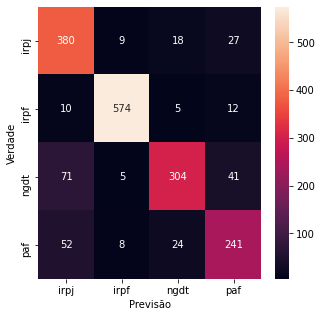

In [ ]:
conf_mat_nb = confusion_matrix(rotulos_teste, lista_predict)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat_nb, annot=True, fmt='d',
            xticklabels=rotulos_plt_cm, yticklabels=rotulos_plt_cm)
plt.ylabel('Verdade')
plt.xlabel('Previsão')
plt.show()

In [ ]:
accuracy_score(rotulos_teste, lista_predict)

0.8416619876473891

##14. Visualização do resultado da classicação com os dados do resumo TextRankSummarizer 


In [ ]:
sumarizador

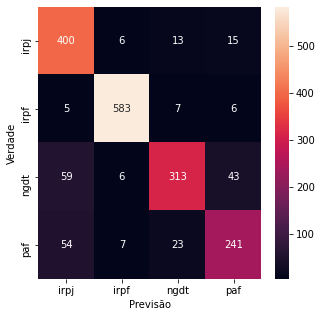

In [ ]:
conf_mat_nb = confusion_matrix(rotulos_teste, lista_predict)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat_nb, annot=True, fmt='d',
            xticklabels=rotulos_plt_cm, yticklabels=rotulos_plt_cm)
plt.ylabel('Verdade')
plt.xlabel('Previsão')
plt.show()

In [ ]:
accuracy_score(rotulos_teste, lista_predict)

0.8629983155530601